In [1]:
import sys
sys.path.append("../../")

In [2]:
SAVE_PATH = "../storage/demo/cnp-MNIST.ckpt"

In [3]:
TENSORBOARD_PATH = "../storage/demo/cnp-MNIST.tb"

# MNIST digit recognition with a CNP

Here I reproduce Figure 3 of Garnelo et al.'s article on conditional neural processes.

In [35]:
from tqdm import tqdm     # Dynamic progress bars
import glob               # Lets us check if checkpoint files exist
import datetime           # Date for tensorboard export
import matplotlib as mplt # Image plotting
import matplotlib.pyplot as plt  
import numpy as np        # 
import tensorflow as tf   # 

In [5]:
tf.logging.set_verbosity(tf.logging.ERROR)  # Suppress depreciation warnings
tf.__version__

'1.13.1'

In [6]:
from neuralprocesses.np.aux import DataProvider
from neuralprocesses.utils.tf_utils import tf_sort_by_col

from neuralprocesses.utils.data_processes import MNISTProcess

from neuralprocesses.np.cnp import ConditionalNeuralProcess
from neuralprocesses.np.encoder import DeterministicMLPEncoder
from neuralprocesses.np.decoder import MLPDecoder

from neuralprocesses.utils.plotting import list_plot
from neuralprocesses.utils.plotting import Color


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [7]:
tf.reset_default_graph()
tf.set_random_seed(2019)

## Data provider

Setup a Gaussian process that provides the environment we want to sample from.

In [8]:
BATCH_SIZE = 32  # ToDo: Can we make this a placeholder?

In [9]:
plotting_mode = tf.placeholder(dtype=tf.bool, name="plotting_mode")
process = MNISTProcess()
data_provider = DataProvider(
    process, 
    batch_size=BATCH_SIZE,
    domain=(0, 1),
    min_num_context_points=80,
    max_num_context_points=300,
    min_num_target_points=80,
    max_num_target_points=500,
    plot_settings={"num_context": 28*28, "num_coordinates": 28*28}
)

In [10]:
data = data_provider(plotting_mode=plotting_mode)

In [11]:
x_context = data.queries[0][0]
y_context = data.queries[0][1]
x_target = data.queries[1]

## CNP model setup and training

### Setup

In [12]:
cnp = ConditionalNeuralProcess(
    #encoder=DeterministicMLPEncoder([128, 128, 128, 128]),
    #decoder=MLPDecoder([128, 128, 128, 128]),
    name="cnp-model"
)

In [13]:
mean, variance, loss = cnp(data)

In [14]:
with tf.variable_scope("cnp_trainer"):
    global_step = tf.Variable(0, name='global_step', trainable=False)
    optimizer = tf.train.AdamOptimizer()
    training_step = optimizer.minimize(loss, global_step=global_step)

### Training

In [15]:
init = tf.global_variables_initializer()
saver = tf.train.Saver( 
            max_to_keep=4, 
            keep_checkpoint_every_n_hours=1
        )

In [16]:
with tf.variable_scope("summary"):
        tf.summary.scalar("loss", loss)
        summary_variables = tf.summary.merge_all()

Picking up training from ../storage/demo/cnp-MNIST.ckpt/training-380000
Initial global step: 380000


 25%|██▍       | 24998/100000 [15:20<47:36, 26.26it/s]  

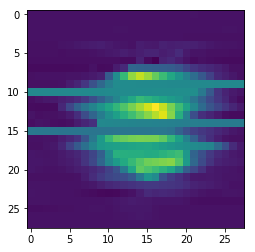

 50%|████▉     | 49999/100000 [30:32<30:40, 27.17it/s]  

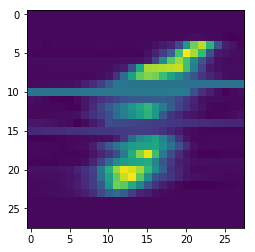

 75%|███████▍  | 74997/100000 [45:55<16:18, 25.55it/s]  

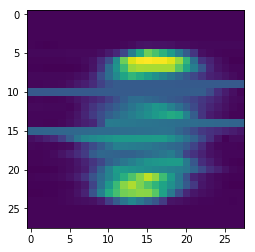

100%|█████████▉| 99997/100000 [1:01:19<00:00, 27.22it/s]

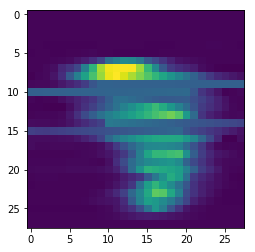

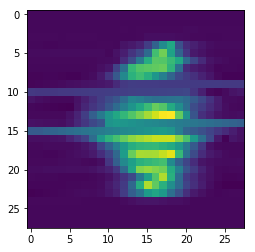

100%|██████████| 100000/100000 [1:01:22<00:00,  2.66it/s]


Model saved in: ../storage/demo/cnp-MNIST.ckpt/training
Final global step: 480000


In [17]:
NUM_EPISODES = 100000
SAVE_STEP = 25000

with tf.Session() as session:
    
    # Initialize variables
    session.run(init)
    
    # Continue training at last checkpoint, if available
    checkpoint = tf.train.latest_checkpoint(SAVE_PATH)
    if checkpoint is not None:
        print(f"Picking up training from {checkpoint}")
        saver.restore(session, checkpoint)
    
    print(f"Initial global step: {session.run(global_step)}")

    name = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    writer = tf.summary.FileWriter(TENSORBOARD_PATH + "/" + name, session.graph)

    # Do training
    for episode in tqdm(range(1, NUM_EPISODES + 1)):
        _, summary = session.run([training_step, summary_variables], 
                                    feed_dict={plotting_mode: False})

        if episode % 10 == 0:
            writer.add_summary(summary, episode)

        if episode % SAVE_STEP == 0 or episode == NUM_EPISODES - 1:
            saver.save(session, SAVE_PATH + "/training", global_step=global_step)

            img = session.run(tf.reshape(mean[0], (28, 28)), feed_dict={plotting_mode: True})
            plt.imshow(img)
            plt.show()

    # Save resulting graph
    saver.save(session, SAVE_PATH + "/training", global_step=global_step)
    print("Model saved in: " + SAVE_PATH + "/training")
    print(f"Final global step: {session.run(global_step)}")

    # Finish writing for tensorboard
    writer.close()

### Prediction function

In [18]:
def cnp_predict(xc, yc):
    with tf.Session() as session:
        checkpoint = tf.train.latest_checkpoint(SAVE_PATH)
        if checkpoint is not None:
            saver.restore(session, checkpoint)
        else:
            raise RuntimeError("No checkpoint.")
        
        xt = np.arange(0, 28**2, dtype=float)/28**2
        batch_size = BATCH_SIZE  # ToDo: How can we change the batch size after loading?

        # Compute a test case for plotting
        m, v, l = session.run(
            [tf.reshape(mean[0], (28, 28)), tf.reshape(variance[0], (28, 28)), loss],
            feed_dict={
                plotting_mode: True,
                data.queries[0][0]: [xc for b in range(batch_size)],
                data.queries[0][1]: [yc for b in range(batch_size)],
                data.queries[1]: [xt for b in range(batch_size)],
                data.num_context: len(xc),
                data.num_target: len(xt)
            }
        )
        
        return m, v

In [48]:
def example(k):
    # Context point plot
    c = np.ones((28, 28)) * np.nan
    pixel_coordinates = [list(divmod(x, 28)) for x in (xc[:k] * (28**2-1)).astype(int)]
    for i in range(len(pixel_coordinates)):
        u, v = pixel_coordinates[i]
        c[u, v] = yc[i]
        
    # Mean and variance plots
    m, v = cnp_predict(xc[:k], yc[:k])
    _, axarr = plt.subplots(1, 3)
    
    axarr[0].imshow(c)
    axarr[0].set_title('context points')
    axarr[1].imshow(m)
    axarr[1].set_title('mean')
    axarr[2].imshow(v)
    axarr[2].set_title('variance')

Generate an example to test with.

In [21]:
def prepare_example(i):
    with tf.Session() as session:
        global xc, yc, xt, yt
        xc, yc, xt, yt = session.run([
            x_context[i], y_context[i], x_target[i], data.targets[i]], feed_dict={plotting_mode: True})

In [55]:
prepare_example(0)

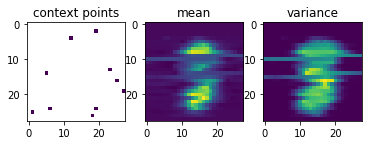

In [56]:
example(10)

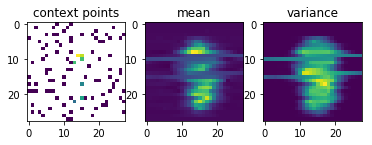

In [57]:
example(100)

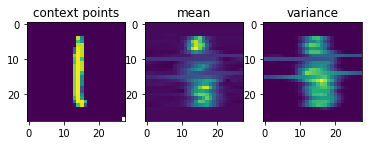

In [58]:
example(28*28)

In [50]:
prepare_example(1)

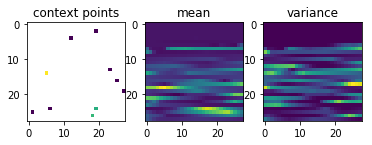

In [51]:
example(10)

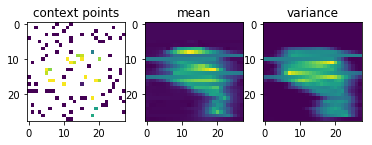

In [52]:
example(100)

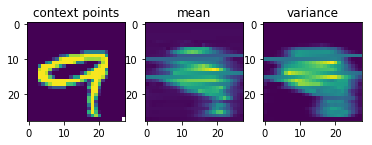

In [54]:
example(28*28)